In [1]:
import pandas as pd
import os, re, json, numpy as np
import datetime
from tqdm import tqdm
import missingno as mso
import matplotlib.pyplot as plt
import matplotlib
from itertools import chain
from collections import Iterable
from matplotlib import colors as cls
import matplotlib.patches as patches
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\955498\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if __name__ == '__main__':


In [2]:
payment = pd.read_csv('payment_transactions.csv')
promo = pd.read_csv('promos.csv')
user = pd.read_csv('users.csv')

# USER

In [3]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328721 entries, 0 to 1328720
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1328721 non-null  int64  
 1   email_domain     1328721 non-null  float64
 2   created_at       1328721 non-null  int64  
 3   first_paid_at    1286814 non-null  float64
 4   first_upload_at  512793 non-null   float64
 5   gender           1328721 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 60.8 MB


In [4]:
user.describe()

,id,email_domain,created_at,first_paid_at,first_upload_at,gender
count,1.328721e+06,1.328721e+06,1.328721e+06,1.286814e+06,5.127930e+05,1.328721e+06
mean,3.521425e+07,3.150247e+03,1.354773e+12,1.365685e+12,1.363341e+12,2.337677e-01
std,2.390489e+07,1.850267e+03,3.789188e+10,3.055692e+10,4.051798e+10,4.234734e-01
min,5.000000e+00,0.000000e+00,1.140103e+12,1.210665e+12,1.134890e+12,0.000000e+00
25%,1.272020e+07,2.138000e+03,1.331336e+12,1.346996e+12,1.340837e+12,0.000000e+00
50%,3.316897e+07,2.138000e+03,1.365222e+12,1.377918e+12,1.373773e+12,0.000000e+00
75%,6.062088e+07,2.473000e+03,1.387771e+12,1.390381e+12,1.390359e+12,0.000000e+00
max,7.102254e+07,6.795000e+03,1.392915e+12,1.436279e+12,1.436301e+12,2.000000e+00


![dtype](dtype_np.png)

- id : identitas unique user 
- email_domain : domain dari email yang digunakan user
- created_at : waktu pembuatan akun
- first_paid_at : waktu pertama kali user membayar/membeli
- first_upload_at : waktu pertama kali user upload lapak
- gender : gender user

In [5]:
user['created_at'] = pd.to_datetime(user.created_at, unit='ms')
user['first_paid_at'] = pd.to_datetime(user.first_paid_at, unit='ms')
user['first_upload_at'] = pd.to_datetime(user.first_upload_at, unit='ms')
user['count'] = np.int8(1)
#reduce memory dataframe
user['email_domain'] = user['email_domain'].astype(np.int16)
user['gender'] = user['gender'].astype(np.int8)
user['id'] = user['id'].astype(np.int32)

In [6]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328721 entries, 0 to 1328720
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   id               1328721 non-null  int32         
 1   email_domain     1328721 non-null  int16         
 2   created_at       1328721 non-null  datetime64[ns]
 3   first_paid_at    1286814 non-null  datetime64[ns]
 4   first_upload_at  512793 non-null   datetime64[ns]
 5   gender           1328721 non-null  int8          
 6   count            1328721 non-null  int8          
dtypes: datetime64[ns](3), int16(1), int32(1), int8(2)
memory usage: 40.5 MB


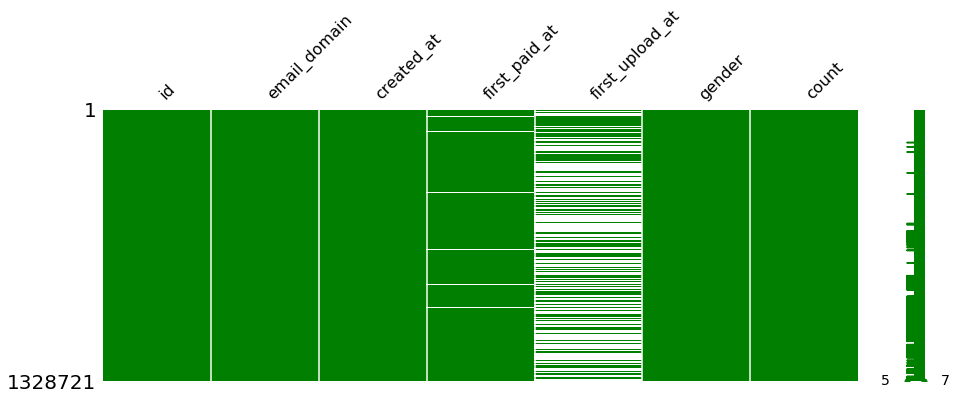

In [7]:
#check missing value
mso.matrix(user,color=(0, 0.5, 0), figsize=(15,5));

kolom first_upload_at paling banyak missing value diikuti dengan data first_paid_at

In [8]:
#cek duplikasi data by kolom id
user[user.duplicated(['id'])].shape

(225, 7)

In [9]:
#cek duplikasi data berdasarkan keseluruhan kolom
user[user.duplicated()].shape

(0, 7)

In [10]:
#cek apakah kolom gender bernilai unique
user[user.duplicated([column for column in user.columns if column != 'gender'])].shape

(225, 7)

In [11]:
user.groupby('gender').size()

gender
0    1018248
1     310334
2        139
dtype: int64

asumsi : 
- gender
    > 0 : male
    
    > 1 : female
    
    > 2 : undefined
    
    
shape dari dataframe duplicated by id dan tanpa disertai kolom gender sama, artinya data di kolom gender terdapat perbedaan nilai, maka asumsikan bahwa jika ada data gender bernilai 2 (dianggap undefined) pada data duplikat, maka dapat kita hapus, jika gender bernilai 1 dan 0 pada data duplicate, maka diambil data terbaru (urutan index paling atas)




(questions) apakah gender 2 ada di data duplikat seluruhnya?

In [12]:
user[(user.duplicated(['id'],keep=False)) & (user.gender==2)].shape

(139, 7)

In [13]:
user = user[user['gender']!=2].drop_duplicates('id', keep='first').reset_index(drop=True)
user.shape

(1328496, 7)

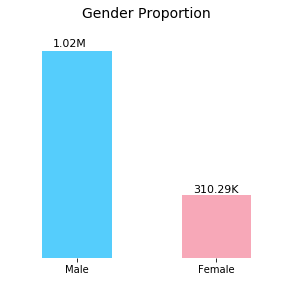

In [14]:
def formating(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

colors = {0:'#55CDFC',
          1:'#F7A8B8'}

dg = user.groupby('gender')['count'].sum().to_frame().rename(index={0:'Male',1:'Female'})
my_color = [list(matplotlib.colors.to_rgba(colors[i])) for i in [0,1]]
fig,ax=plt.subplots(figsize=(5,4))
dg.plot(kind='bar', width=.5, legend=False,ax=ax, color=[np.array(my_color)])
ax.set_ylabel('')
for i in ax.spines:
    ax.spines[i].set_visible(False)
ax.set_yticks([])
yloc = len(dg)-1.17
for value in list(dg.sort_values('count')['count']):
    if value != 0:
       
        xloc = value+0.02*value
        ax.annotate(s=formating(value), 
                    xy=(yloc,xloc), 
                    xycoords=('data', 'data'), 
                    color='k',size=11)
    yloc-=1
plt.xticks(rotation=0)
plt.xlabel('')
plt.title('Gender Proportion\n', size=14);

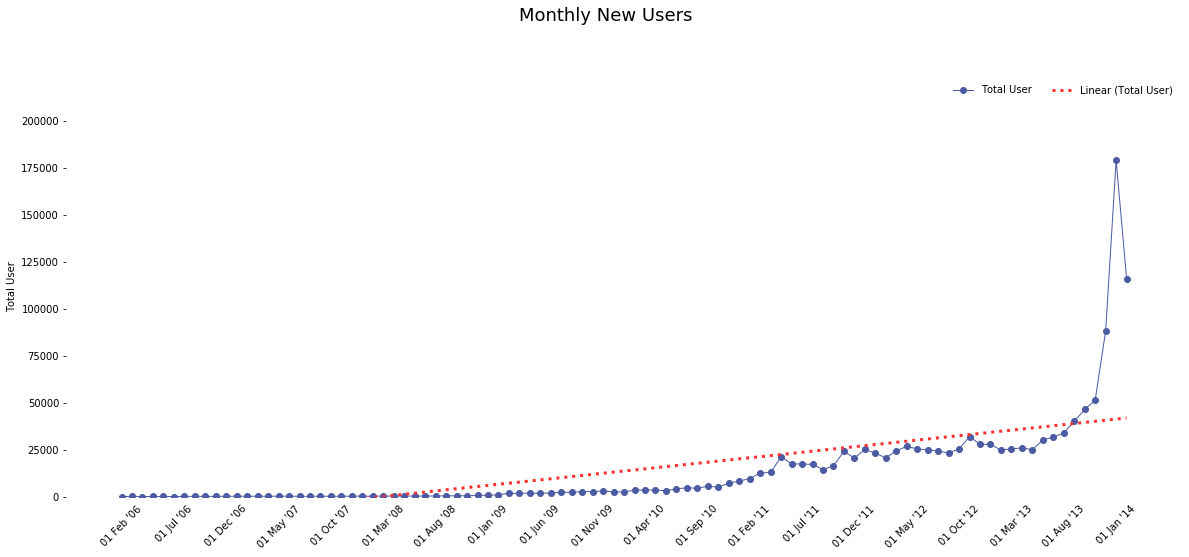

In [15]:
types = 'MS'
a = user.groupby(pd.Grouper(key='created_at',freq=types)).sum()[['count']]\
                    .fillna(0).rename(columns={'count':'Total User'})
x1 = a.index
x2 = x1.map(datetime.datetime.toordinal)
y1 = a["Total User"]
z = np.polyfit(x2,y1,1)
p = np.poly1d(z)

a = a.reset_index()
title = 'Monthly New Users'
a['Linear (Total User)'] = p(x2)
label = a.reset_index()["created_at"].apply(lambda x:datetime.datetime.strftime(x, "%d %b \'%y"))

b = a[["Total User",'Linear (Total User)']]
fig,ax=plt.subplots(figsize=(20,8))

a.plot(kind="line", y="Total User", ax=ax, linewidth=1, color="#4C5BA4", 
       marker='o')
a.plot(kind='line', y='Linear (Total User)', ax=ax, linestyle=':', color='#FD3030', linewidth=3, 
       ylim=(0,max(b.max())+max(b.max())*0.25))

ax.set_xlabel('')
ax.set_ylabel('Total User')
# ax.set_xticklabels(label,rotation = 45)
xticks_range = range(0,len(label),5)
plt.xticks(xticks_range, label[::5], rotation=45)
ax.tick_params(which='major',  axis='x', color='w')
# plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.15)
for loc in ['top','left','bottom','right']:
    ax.spines[loc].set_color('dimgrey')

xlim = ax.get_xlim()
ax.set_xlim([xlim[0]-0.5,xlim[1]+0.5])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.legend( ncol=2, frameon=False)
plt.suptitle(title, size=18, y=1);

pertumbuhan pengguna baru memiliki trend yang baik untuk setiap bulan

kategorisasi user:
- jika user hanya memiliki first_paid_at maka disebut buyer
- jika user hanya memiliki first_upload_at maka disebut seller
- jika memiliki keduanya, disebut buyer&seller
- jika tidak memiliki keduanya, disebut inactive

## forecasting

In [16]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [17]:
def evaluate_arima_model(X, arima_order):
    #training
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # prediksi
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # perhitungan eror
    error = mean_squared_error(test, predictions)
    return error
 
# cek kombinasi ordo p,q,d
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except Exception as e:
                    pass
    print('Arima terbaik dengan%s MSE=%.3f' % (best_cfg, best_score))




In [18]:
#nilai ordo yang akan di tuning    
p_values = range(7)
d_values = range(4)
q_values = range(7)

import warnings
warnings.filterwarnings("ignore")
evaluate_models(a['Total User'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2756775854.772
ARIMA(0, 0, 1) MSE=1027215238.631
ARIMA(0, 0, 2) MSE=821329876.701
ARIMA(0, 1, 0) MSE=690156053.817
ARIMA(0, 1, 1) MSE=1067139774.121
ARIMA(0, 1, 2) MSE=1398362414.035
ARIMA(0, 1, 4) MSE=1920950212.824
ARIMA(0, 2, 0) MSE=1405664225.378
ARIMA(0, 2, 1) MSE=1814009041.260
ARIMA(0, 2, 2) MSE=1967753245.504
ARIMA(0, 2, 3) MSE=2258702337.774
ARIMA(1, 0, 0) MSE=687317915.349
ARIMA(1, 1, 0) MSE=1541460437.028
ARIMA(1, 2, 0) MSE=2072546662.719
ARIMA(2, 1, 0) MSE=2059845695.610
ARIMA(2, 2, 0) MSE=2283759421.654
ARIMA(2, 2, 1) MSE=2259370939.633
ARIMA(3, 2, 0) MSE=2179931756.517
ARIMA(4, 2, 0) MSE=2365078076.794
ARIMA(6, 2, 0) MSE=2702564172.002
Arima terbaik dengan(1, 0, 0) MSE=687317915.349


In [19]:
model = ARIMA(a['Total User'], order=(1, 0, 0))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Total User   No. Observations:                   97
Model:                     ARMA(1, 0)   Log Likelihood               -1049.758
Method:                       css-mle   S.D. of innovations          11996.423
Date:                Thu, 17 Sep 2020   AIC                           2105.516
Time:                        13:23:02   BIC                           2113.240
Sample:                             0   HQIC                          2108.639
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.082e+04   1.73e+04      1.202      0.229   -1.31e+04    5.48e+04
ar.L1.Total User     0.9383      0.044     21.086      0.000       0.851       1.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0658           +0.0000j            1.0658            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
fit_model.forecast(steps=20)[0]

array([110252.66439111, 104730.71621251,  99549.7182689 ,  94688.61873962,
        90127.66563932,  85848.3265602 ,  81833.21336973,  78066.01155792,
        74531.41394692,  71215.05849377,  68103.46993348,  65184.0050253 ,
        62444.80117975,  59874.72825767,  57463.3433454 ,  55200.84832233,
        53078.05004846,  51086.32301012,  49217.57427215,  47464.21059409])

In [21]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):    
   rolling_mean = ts.rolling(window=window).mean()    
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)    
   plt.title(ts.name)    
   plt.plot(ts[window:], label='Actual values', color="black")    
   if plot_ma:        
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
   if plot_intervals:
      lower_bound = rolling_mean - (1.96 * rolling_std)
      upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.show()

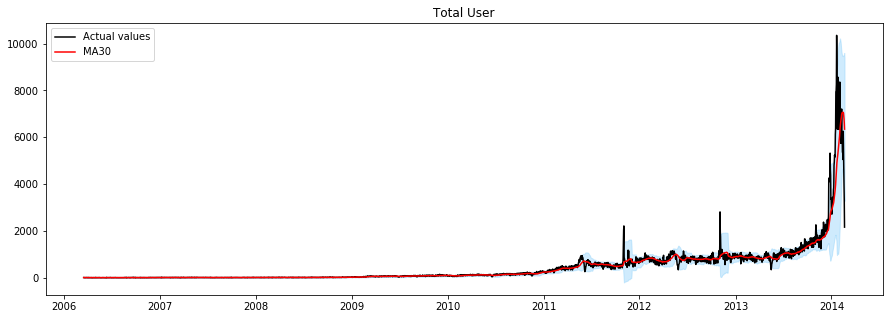

In [22]:
types = 'D'
total = user.groupby(pd.Grouper(key='created_at',freq=types)).sum()[['count']]

user_day = total.rename(columns={'count':'Total User'})
plot_ts(user_day['Total User'])

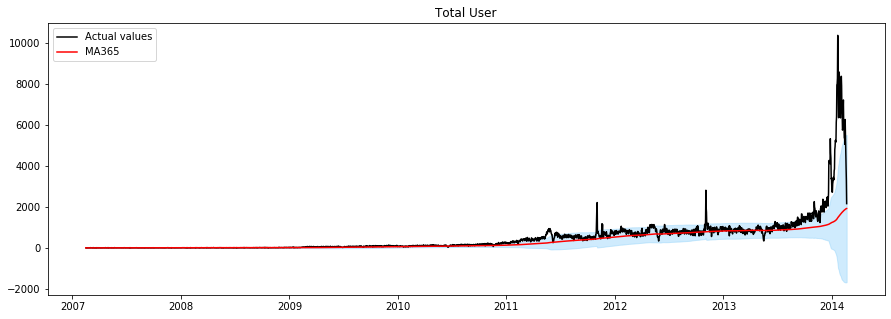

In [23]:
plot_ts(user_day['Total User'], window=365)

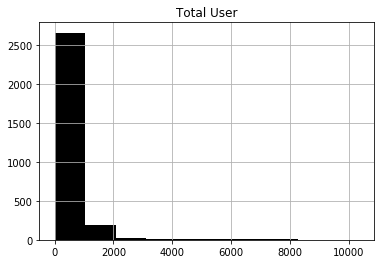

In [24]:
user_day.hist(color="black", bins=10);

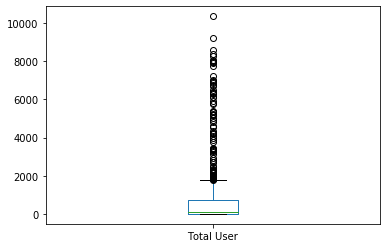

In [25]:
user_day.plot.box()

In [26]:
## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [27]:
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [28]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

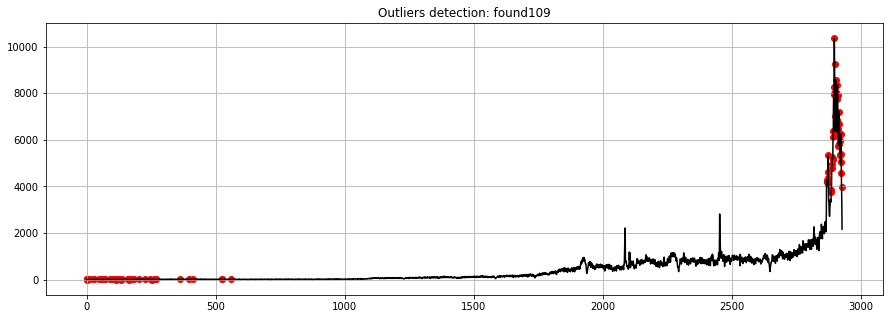

In [29]:
dtf_outliers = find_outliers(user_day['Total User'], perc=0.05)

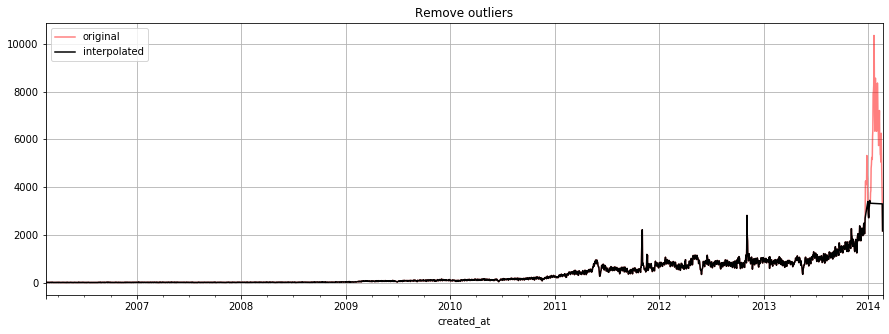

In [30]:
## outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index
## exclude outliers
ts_clean = remove_outliers(user_day['Total User'], outliers_idx=outliers_index_pos)

In [31]:
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize= 
                              (15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red",
                            linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'], 
                y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,
                legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index, 
                           y1=dtf_ts['lower'].head(sample_size), 
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')
        
        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,
                                                  autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+
                        '(p value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax, 
                 title="Partial Autocorrelation (for AR component)")
        smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,
                 title="Autocorrelation (for MA component)")
        plt.tight_layout()

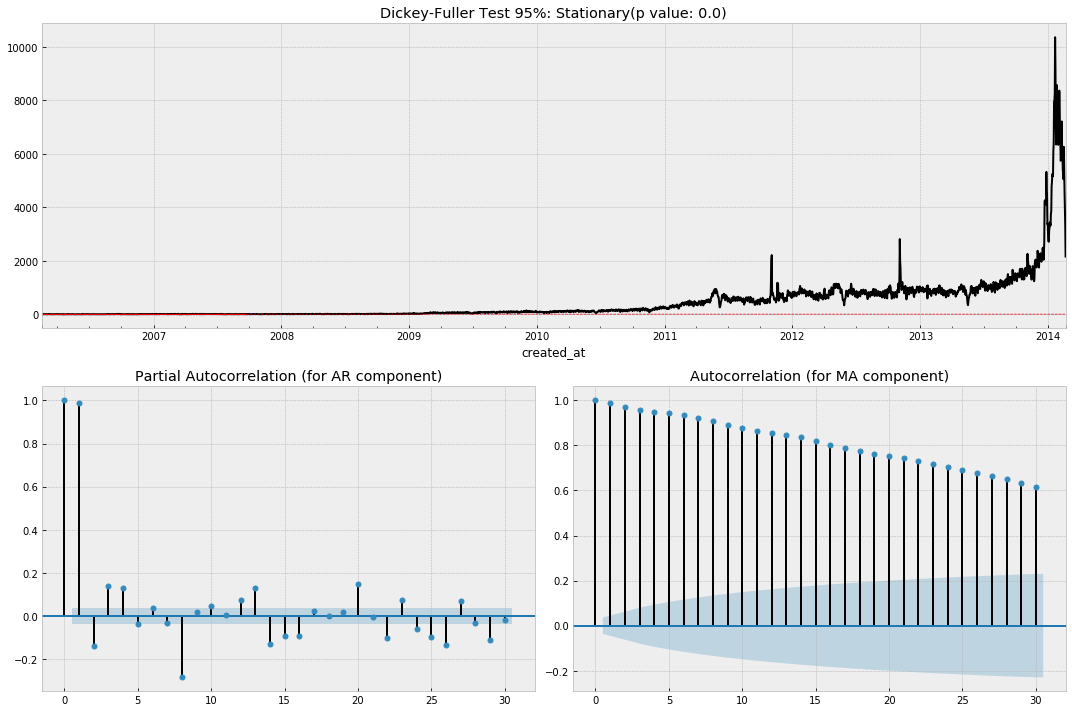

In [32]:
test_stationarity_acf_pacf(user_day['Total User'], sample=0.20, maxlag=30)

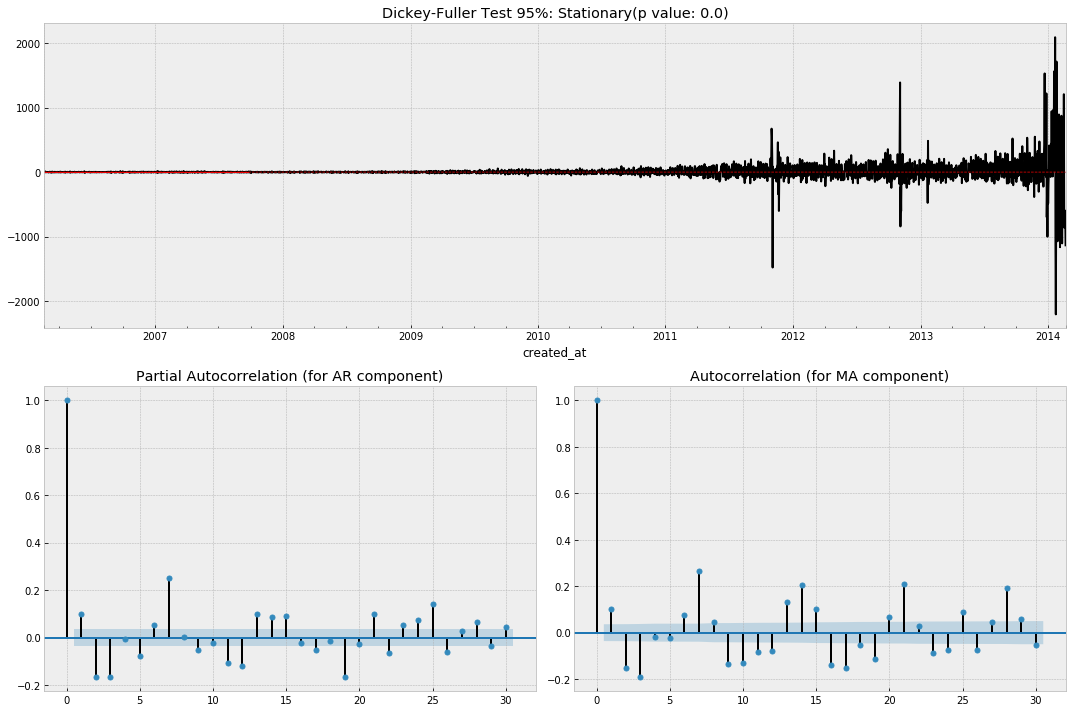

In [33]:
diff_ts = user_day['Total User'] - user_day['Total User'].shift(1)
diff_ts = diff_ts[(pd.notnull(diff_ts))]
test_stationarity_acf_pacf(diff_ts, sample=0.20, maxlag=30)

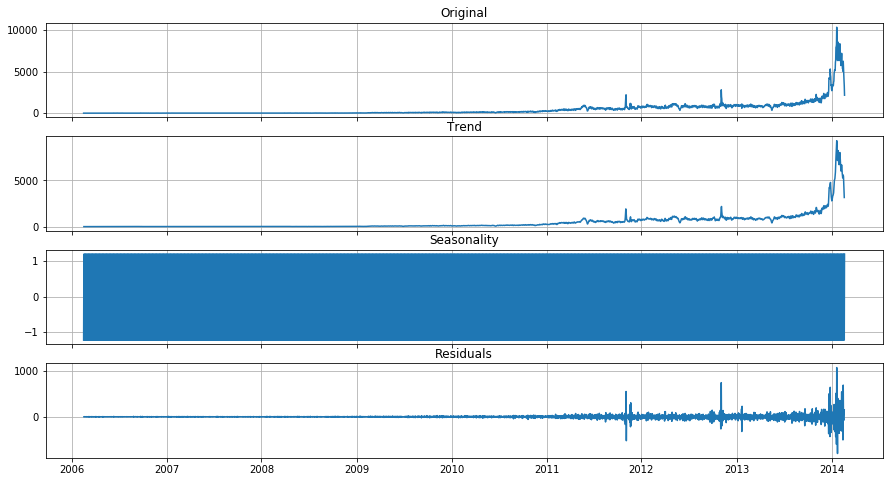

In [34]:
#test sesional
decomposition = smt.seasonal_decompose(user_day['Total User'], freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,8), sharex=True, sharey=False)
ax[0].plot(user_day['Total User'])
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)

In [35]:
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ 
                      ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

--- splitting at index:  2784 | 2013-10-01 00:00:00 | test size: 0.05  ---


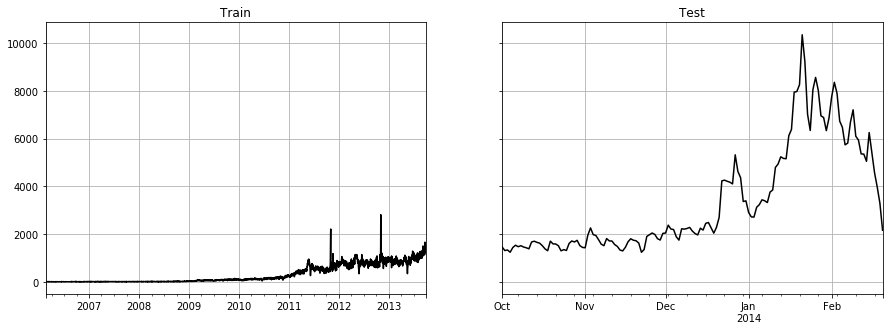

In [36]:
ts_train, ts_test = split_train_test(user_day['Total User'], test="2013-10-01")

In [37]:
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

In [38]:
'''
Fit SARIMAX (Seasonal ARIMA with External Regressors):  
    y[t+1] = (c + a0*y[t] + a1*y[t-1] +...+ ap*y[t-p]) + (e[t] + 
              b1*e[t-1] + b2*e[t-2] +...+ bq*e[t-q]) + (B*X[t])
:parameter
    :param ts_train: pandas timeseries
    :param ts_test: pandas timeseries
    :param order: tuple - ARIMA(p,d,q) --> p: lag order (AR), d: 
                  degree of differencing (to remove trend), q: order 
                  of moving average (MA)
    :param seasonal_order: tuple - (P,D,Q,s) --> s: number of 
                  observations per seasonal (ex. 7 for weekly 
                  seasonality with daily data, 12 for yearly 
                  seasonality with monthly data)
    :param exog_train: pandas dataframe or numpy array
    :param exog_test: pandas dataframe or numpy array
:return
    dtf with predictons and the model
'''
def fit_sarimax(ts_train, ts_test, order=(1,0,1), 
                seasonal_order=(0,0,0,0), exog_train=None, 
                exog_test=None, figsize=(15,10)):
    ## train
    model = smt.SARIMAX(ts_train, order=order, 
                        seasonal_order=seasonal_order, 
                        exog=exog_train, enforce_stationarity=False, 
                        enforce_invertibility=False).fit()
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.fittedvalues
    
    ## test
    dtf_test = ts_test.to_frame(name="ts")
    dtf_test["forecast"] = model.predict(start=len(ts_train), 
                            end=len(ts_train)+len(ts_test)-1, 
                            exog=exog_test)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    title = "ARIMA "+str(order) if exog_train is None else "ARIMAX "+str(order)
    title = "S"+title+" x "+str(seasonal_order) if np.sum(seasonal_order) > 0 else title
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, title=title)
    return dtf, model

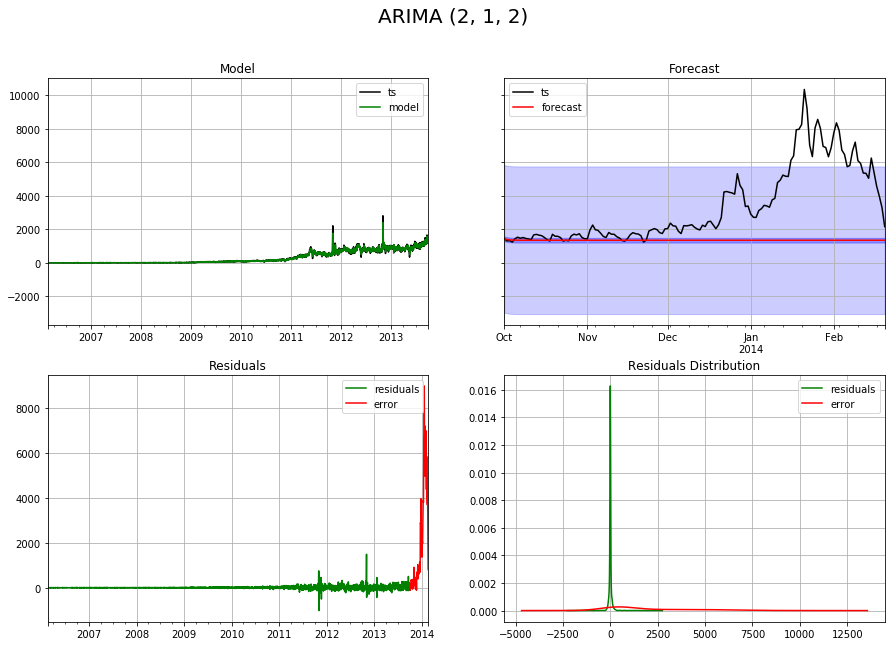

Training --> Residuals mean: 3.0  | std: 72.0
Test --> Error mean: 2014.0  | std: 2248.0  | mae: 2022.0  | mape: 43.0 %  | mse: 9073757.0  | rmse: 3012.0


In [40]:
dtf, model = fit_sarimax(ts_train, ts_test, order=(2,1,2), 
                         seasonal_order=(0,0,0,0))

## category

In [41]:
def category(data):
    if not pd.isna(data['first_paid_at']) and not pd.isna(data['first_upload_at']):
        return 'buyer&seller'
    if not pd.isna(data['first_paid_at']):
        return 'buyer'
    if not pd.isna(data['first_upload_at']):
        return 'seller'
    return 'inactive'

In [42]:
user['category'] = user.apply(category, axis=1)

In [43]:
default_colors = [
    list(cls.to_rgba("#1e980b", alpha=0.4)),
    list(cls.to_rgba("#FF7F5D", alpha=0.4)),
    list(cls.to_rgba("#670797", alpha=0.4)),
    list(cls.to_rgba("#2864c9", alpha=0.4)),
    list(cls.to_rgba("#00a788", alpha=0.4)),
]
def draw_ellipse(fig, ax, x, y, w, h, a, fillcolor):
    e = patches.Ellipse(
        xy=(x, y),
        width=w,
        height=h,
        angle=a,
        color=fillcolor)
    ax.add_patch(e)
def draw_triangle(fig, ax, x1, y1, x2, y2, x3, y3, fillcolor):
    xy = [
        (x1, y1),
        (x2, y2),
        (x3, y3),
    ]
    polygon = patches.Polygon(
        xy=xy,
        closed=True,
        color=fillcolor)
    ax.add_patch(polygon)   
def draw_text(fig, ax, x, y, text, color=[0, 0, 0, 1], fontsize=14, legend=False, bbox_color=None): 
    if not legend:
        ax.text(
            x, y, text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=fontsize,
            color=color,
            alpha=1)
    else:
        ax.text(
            x, y, text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=fontsize,
            color=color,
            bbox=dict(facecolor=bbox_color, alpha=0.1)
        )   
def draw_annotate(fig, ax, x, y, textx, texty, text, color=[0, 0, 0, 1], arrowcolor=[0, 0, 0, 0.3]):
    plt.annotate(
        text,
        xy=(x, y),
        xytext=(textx, texty),
        arrowprops=dict(color=arrowcolor, shrink=0, width=0.5, headwidth=8),
        fontsize=14,
        color=color,
        xycoords="data",
        textcoords="data",
        horizontalalignment='center',
        verticalalignment='center'
    )
def get_labels(data, fill=["number"]):
    """    
    get a dict of labels for groups in data
    
    @type data: list[Iterable]    
    @rtype: dict[str, str]

    input
      data: data to get label for
      fill: ["number"|"logic"|"percent"]

    return
      labels: a dict of labels for different sets

    example:
    In [12]: get_labels([range(10), range(5,15), range(3,8)], fill=["number"])
    Out[12]:
    {'001': '0',
     '010': '5',
     '011': '0',
     '100': '3',
     '101': '2',
     '110': '2',
     '111': '3'}
    """

    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  # sets for separate groups
    s_all = set(chain(*data))                             # union of all sets

    # bin(3) --> '0b11', so bin(3).split('0b')[-1] will remove "0b"
    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split('0b')[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if  key[i] == '1']
        sets_for_difference = [sets_data[i] for i in range(N) if  key[i] == '0']
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    labels = {k: "" for k in set_collections}
    if "logic" in fill:
        for k in set_collections:
            labels[k] = k + ": "
    if "number" in fill:
        for k in set_collections:
            labels[k] += str(len(set_collections[k]))
    if "percent" in fill:
        data_size = len(s_all)
        for k in set_collections:
            labels[k] += "(%.1f%%)" % (100.0 * len(set_collections[k]) / data_size)

    return labels
def venn2(labels, names=['A', 'B'], **options):
    colors = options.get('colors', [default_colors[i] for i in range(3)])
    figsize = options.get('figsize', (15, 7))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)
    
    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=0.7)
    ax.set_xlim(left=0.0, right=1.0)
    
    # body
    draw_ellipse(fig, ax, 0.375, 0.2, 0.3, 0.3, 0.0, colors[0]) #buyer
    draw_ellipse(fig, ax, 0.625, 0.2, 0.3, 0.3, 0.0, colors[1]) #seller
    draw_ellipse(fig, ax, 0.5, 0.5, 0.3, 0.3, 0.0, colors[2]) #inactive
    
    draw_text(fig, ax, 0.7, 0.19, formating(labels.get('01', '')), fontsize=fontsize)
    draw_text(fig, ax, 0.3, 0.19, formating(labels.get('10', '')), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.19, formating(labels.get('11', '')), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.50, formating(labels.get('2', '')), fontsize=fontsize)
    
    # legend
    draw_text(fig, ax, 0.20, 0.3, names[0], colors[0], fontsize=fontsize)
    draw_text(fig, ax, 0.80, 0.3, names[1], colors[1], fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.7, names[2], colors[2], fontsize=fontsize)
    
#     leg = ax.legend(names, loc='best', fancybox=True)
#     leg.get_frame().set_alpha(0.5)
    
    return fig, ax

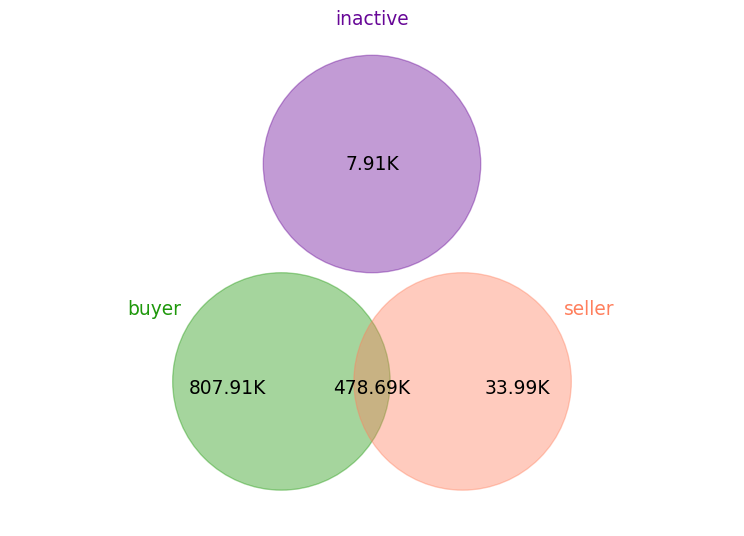

In [44]:
venn2({'01':user[user['category']=='seller'].shape[0],
       '10':user[user['category']=='buyer'].shape[0],
       '11':user[user['category']=='buyer&seller'].shape[0],
       '2':user[user['category']=='inactive'].shape[0]},['buyer','seller','inactive']);

# promos

In [45]:
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388494 entries, 0 to 1388493
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1388494 non-null  int64  
 1   trx_id          1388494 non-null  int64  
 2   promo_type      1388494 non-null  int64  
 3   promo_campaign  1388494 non-null  float64
 4   amount          1388494 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 53.0 MB


In [46]:
promo.describe()

,id,trx_id,promo_type,promo_campaign,amount
count,1.388494e+06,1.388494e+06,1.388494e+06,1.388494e+06,1.388494e+06
mean,4.571321e+07,2.869576e+08,6.196728e-01,1.568420e+02,-1.839495e+00
std,2.681341e+06,1.669681e+07,4.854674e-01,7.016157e+01,4.259687e-01
min,4.127356e+07,2.615557e+08,0.000000e+00,0.000000e+00,-2.934641e+00
25%,4.343091e+07,2.727561e+08,0.000000e+00,1.010000e+02,-1.836041e+00
50%,4.555588e+07,2.843594e+08,1.000000e+00,1.410000e+02,-1.836041e+00
75%,4.786114e+07,2.995279e+08,1.000000e+00,2.290000e+02,-1.836041e+00
max,5.086186e+07,3.225263e+08,1.000000e+00,2.480000e+02,9.773638e-01


In [47]:
promo['id'] = promo['id'].astype(np.int32)
promo['trx_id'] = promo['trx_id'].astype(np.int32)
promo['promo_campaign'] = promo['promo_campaign'].astype(np.int16)
promo['amount'] = promo['amount'].astype(np.float16)

In [48]:
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388494 entries, 0 to 1388493
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1388494 non-null  int32  
 1   trx_id          1388494 non-null  int32  
 2   promo_type      1388494 non-null  int64  
 3   promo_campaign  1388494 non-null  int16  
 4   amount          1388494 non-null  float16
dtypes: float16(1), int16(1), int32(2), int64(1)
memory usage: 26.5 MB


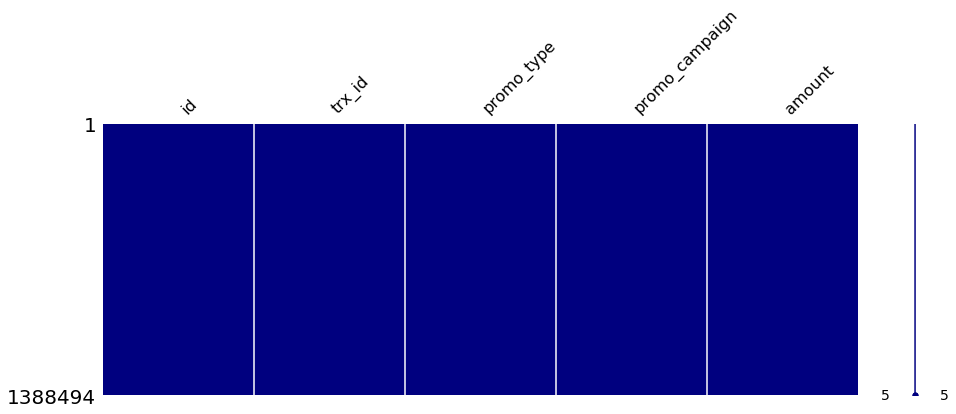

In [49]:
#check missing value
mso.matrix(promo,color=(0, 0, 0.5), figsize=(15,5));

- id : unique promo id
- trx_id : id transaksi
- promo_type : jenis promo
- prmo_campaign : cara campaign promo
- amount : total biaya promo

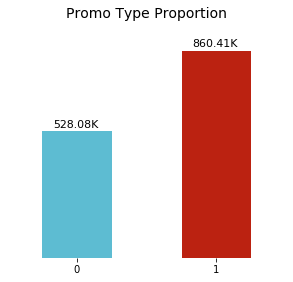

In [50]:
colors = {0:'#5dbcd2',
          1:'#bb2211'}

dg = promo.groupby('promo_type').size().to_frame()
my_color = [list(matplotlib.colors.to_rgba(colors[i])) for i in [0,1]]
fig,ax=plt.subplots(figsize=(5,4))
dg.plot(kind='bar', width=.5, legend=False,ax=ax, color=[np.array(my_color)])
ax.set_ylabel('')
for i in ax.spines:
    ax.spines[i].set_visible(False)
ax.set_yticks([])
yloc = len(dg)-1.17
for value in dg.sort_values(0, ascending=False)[0].values:
    if value != 0:
        xloc = value+0.02*value
        ax.annotate(s=formating(value), 
                    xy=(yloc,xloc), 
                    xycoords=('data', 'data'), 
                    color='k',size=11)
    yloc-=1
plt.xticks(rotation=0)
plt.xlabel('')
plt.title('Promo Type Proportion\n', size=14);

# payment

In [51]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750623 entries, 0 to 3750622
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   buyer_id        int64  
 2   seller_id       int64  
 3   created_at      int64  
 4   paid_at         int64  
 5   remitted_at     float64
 6   refunded_at     float64
 7   gmv             float64
 8   courier_cost    float64
 9   payment_method  float64
 10  platform        float64
 11  courier         float64
 12  from_city       float64
 13  weight          float64
dtypes: float64(9), int64(5)
memory usage: 400.6 MB


In [52]:
payment.describe()

,id,buyer_id,seller_id,created_at,paid_at,remitted_at,refunded_at,gmv,courier_cost,payment_method,platform,courier,from_city,weight
count,3.750623e+06,3.750623e+06,3.750623e+06,3.750623e+06,3.750623e+06,3.530322e+06,2.238310e+05,3.750623e+06,3.750623e+06,3.750623e+06,3.750623e+06,3.750623e+06,3.750623e+06,3.750623e+06
mean,2.892057e+08,3.490022e+07,2.283092e+07,1.391513e+12,1.391518e+12,1.391816e+12,1.391818e+12,-4.200702e-01,-2.737952e+00,7.365315e+00,2.572862e+00,1.167625e+01,1.762261e+02,7.712150e-11
std,1.692760e+07,2.400249e+07,2.030268e+07,7.767930e+08,7.765102e+08,8.512007e+08,9.697129e+08,1.180890e+00,1.851514e+00,5.356425e+00,1.533905e+00,4.377903e+00,1.189151e+02,1.375298e+00
min,1.243756e+08,-1.000000e+00,-1.000000e+00,1.380622e+12,1.390237e+12,1.390251e+12,1.388953e+12,-7.537962e+00,-1.382165e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.290621e+00
25%,2.745664e+08,1.169085e+07,5.654785e+06,1.390817e+12,1.390821e+12,1.391097e+12,1.391150e+12,-1.062855e+00,-3.039999e+00,3.000000e+00,2.000000e+00,1.000000e+01,1.310000e+02,-8.026994e-01
50%,2.873332e+08,3.358838e+07,1.653162e+07,1.391473e+12,1.391478e+12,1.391772e+12,1.391823e+12,-5.367627e-01,-2.598174e+00,6.000000e+00,2.000000e+00,1.100000e+01,1.330000e+02,1.098190e-01
75%,3.030016e+08,5.990769e+07,3.913526e+07,1.392183e+12,1.392187e+12,1.392470e+12,1.392486e+12,1.098637e-01,-2.059183e+00,1.000000e+01,2.000000e+00,1.100000e+01,1.950000e+02,8.017056e-01
max,3.225270e+08,7.102254e+07,7.098985e+07,1.392916e+12,1.392916e+12,1.436265e+12,1.425703e+12,7.728215e+00,4.104124e+00,1.800000e+01,9.000000e+00,2.400000e+01,4.380000e+02,1.128615e+01


In [53]:
payment['id'] = payment['id'].astype(np.int32)
payment['buyer_id'] = payment['buyer_id'].astype(np.int32)
payment['seller_id'] = payment['seller_id'].astype(np.int32)
payment['gmv'] = payment['gmv'].astype(np.float16)
payment['courier_cost'] = payment['courier_cost'].astype(np.float16)
payment['platform'] = payment['platform'].astype(np.int8)
payment['courier'] = payment['courier'].astype(np.int16)
payment['from_city'] = payment['from_city'].astype(np.int16)
payment['weight'] = payment['weight'].astype(np.float16)
payment['payment_method'] = payment['payment_method'].astype(np.int16)

In [54]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750623 entries, 0 to 3750622
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int32  
 1   buyer_id        int32  
 2   seller_id       int32  
 3   created_at      int64  
 4   paid_at         int64  
 5   remitted_at     float64
 6   refunded_at     float64
 7   gmv             float16
 8   courier_cost    float16
 9   payment_method  int16  
 10  platform        int8   
 11  courier         int16  
 12  from_city       int16  
 13  weight          float16
dtypes: float16(3), float64(2), int16(3), int32(3), int64(2), int8(1)
memory usage: 203.9 MB


- id : id transaction
- buyer_id : id for buyer
- seller_id : id for seller
- created_at : waktu barang masuk keranjang
- paid_at : waktu pembayaran
- remitted_at : waktu pengiriman
- refunded_at : waktu pengembalian
- gmv : gross merchandise value
- courier_cost : biaya pengiriman
- payment_method : cara pembayaran
- platform : platform
- courier : pengirim
- from_city : kota dari buyer
- weight : weight

In [55]:
#dont running this if you just have core i3 
#check missing value

# mso.matrix(payment,color=(0.2, 0, 0), figsize=(15,5));

In [57]:
from dateutil import tz
payment['created_at'] =  pd.to_datetime(payment.created_at, unit='ms',)
payment['created_day'] =  payment['created_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%A'))
payment['created_hour'] =  payment['created_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%H'))

payment['paid_at'] = pd.to_datetime(payment.paid_at, unit='ms')
payment['paid_day'] =  payment['paid_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%A'))
payment['paid_hour'] =  payment['paid_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%H'))

payment['remitted_at'] = pd.to_datetime(payment.remitted_at, unit='ms')
payment['remitted_day'] =  payment['remitted_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%A') if not pd.isna(s) else s)
payment['remitted_hour'] =  payment['remitted_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%H') if not pd.isna(s) else s)

payment['refunded_at'] = pd.to_datetime(payment.refunded_at, unit='ms')
payment['refunded_day'] =  payment['refunded_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%A') if not pd.isna(s) else s)
payment['refunded_hour'] =  payment['refunded_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()).strftime('%H') if not pd.isna(s) else s)

In [58]:
payment['gap_created_paid'] = pd.to_datetime(payment['paid_at'])-pd.to_datetime(payment['created_at'])
payment['gap_paid_remitted'] = pd.to_datetime(payment['remitted_at'])-pd.to_datetime(payment['paid_at'])
payment['gap_remitted_refunded'] = pd.to_datetime(payment['refunded_at'])-pd.to_datetime(payment['remitted_at'])
payment['gap_paid_refunded'] = pd.to_datetime(payment['refunded_at'])-pd.to_datetime(payment['paid_at'])

# merging all data

## user + payment

In [60]:
user_payment = payment.merge(user.rename(columns={'id':'user_id'}), left_on = 'buyer_id', right_on = 'user_id')

In [61]:
user_domisili = user_payment.groupby('user_id')['from_city'].apply(set).to_frame()
user_domisili = user_domisili.reset_index()
user_domisili['count'] = user_domisili.from_city.transform(lambda s: len(s))
user_domisili.sort_values('count')

,user_id,from_city,count
0,5,{438},1
723047,47229193,{131},1
723049,47229308,{405},1
723050,47229488,{132},1
723051,47229548,{18},1
...,...,...,...
33829,617520,"{128, 131, 133, 134, 136, 393, 139, 396, 17, 1...",44
57558,1477878,"{131, 132, 133, 134, 135, 8, 261, 136, 396, 15...",45
156051,5911510,"{131, 133, 262, 135, 136, 393, 134, 396, 144, ...",46
592076,33646112,"{131, 132, 133, 134, 135, 262, 261, 396, 13, 1...",48


In [62]:
user_with_domisili = user.merge(user_domisili.rename(columns={'count':'domisili_count'}),left_on = 'id', right_on='user_id', how = 'outer')
user_with_domisili = user_with_domisili.drop('user_id',axis=1).fillna(value={'domisili_count':0})
user_with_domisili.head(2)

,id,email_domain,created_at,first_paid_at,first_upload_at,gender,count,category,from_city,domisili_count
0,65598151,2138,2014-01-21 11:57:10,2014-01-25 03:44:10,NaT,1,1,buyer,{437},1.0
1,66861351,2649,2014-01-29 13:50:03,2014-01-30 03:42:12,NaT,0,1,buyer,{183},1.0


In [63]:
user_with_domisili['domisili_count'] = user_with_domisili['domisili_count'].astype(np.int8)

## promo + payment

In [64]:
payment_with_promo = promo.rename(columns={'id':'promo_id'}).merge(payment,left_on = 'trx_id', right_on = 'id',how='outer')
payment_with_promo.head(2)

,promo_id,trx_id,promo_type,promo_campaign,amount,id,buyer_id,seller_id,created_at,paid_at,...,paid_day,paid_hour,remitted_day,remitted_hour,refunded_day,refunded_hour,gap_created_paid,gap_paid_remitted,gap_remitted_refunded,gap_paid_refunded
0,46478917.0,289827077.0,1.0,229.0,-1.835938,289827077,66679816,8358318,2014-02-05 08:22:16,2014-02-05 08:22:43,...,Wednesday,08,Sunday,03,NaT,NaT,00:00:27,3 days 18:41:21,NaT,NaT
1,46553917.0,290371792.0,0.0,101.0,-2.242188,290371792,34214363,3595840,2014-02-05 14:05:35,2014-02-05 14:15:24,...,Wednesday,14,Saturday,08,NaT,NaT,00:09:49,2 days 18:18:39,NaT,NaT


In [65]:
payment_with_promo = payment_with_promo.drop('trx_id',axis=1).rename(columns={'id':'trx_id'})
payment_with_promo['promo'] = np.where(pd.isna(payment_with_promo['promo_id']),0,1)
payment_with_promo['refunded'] = np.where(pd.isna(payment_with_promo['refunded_at']),0,1)

In [66]:
#time for costumer to paid
payment_with_promo['spend_time_buying'] = payment_with_promo['gap_created_paid'].transform(lambda s: s.total_seconds()/3600)
#time for remitted
payment_with_promo['spend_time_remitted'] = payment_with_promo['gap_paid_remitted'].transform(lambda s: s.total_seconds()/3600)

In [67]:
#save point untuk digunakan di script lain
payment_with_promo.to_csv('payment_promo.csv',index=False)
user_with_domisili.to_csv('user_with_domisili.csv',index=False)

# user segmentation : buyer only

In [68]:
buyer = user_with_domisili[user_with_domisili['category'].str.contains('buyer')]

In [69]:
#buyer:1
#buyer&seller:2
buyer = buyer.drop(['created_at','first_paid_at','first_upload_at','count'], axis=1).replace({'buyer':1,'buyer&seller':2})

In [70]:
buyer['count'] = np.int8(1)
buyer.head(2)

,id,email_domain,gender,category,from_city,domisili_count,count
0,65598151,2138,1,1,{437},1,1
1,66861351,2649,0,1,{183},1,1


In [71]:
payment_with_promo.head()

,promo_id,promo_type,promo_campaign,amount,trx_id,buyer_id,seller_id,created_at,paid_at,remitted_at,...,refunded_day,refunded_hour,gap_created_paid,gap_paid_remitted,gap_remitted_refunded,gap_paid_refunded,promo,refunded,spend_time_buying,spend_time_remitted
0,46478917.0,1.0,229.0,-1.835938,289827077,66679816,8358318,2014-02-05 08:22:16,2014-02-05 08:22:43,2014-02-09 03:04:04,...,NaT,NaT,00:00:27,3 days 18:41:21,NaT,NaT,1,0,0.007500,90.689167
1,46553917.0,0.0,101.0,-2.242188,290371792,34214363,3595840,2014-02-05 14:05:35,2014-02-05 14:15:24,2014-02-08 08:34:03,...,NaT,NaT,00:09:49,2 days 18:18:39,NaT,NaT,1,0,0.163611,66.310833
2,46518017.0,1.0,229.0,-1.835938,290084112,17380520,14232412,2014-02-05 11:09:17,2014-02-05 11:09:47,NaT,...,Thursday,00:00:00.000000,00:00:30,NaT,NaT,1 days 00:00:03,1,1,0.008333,NaN
3,46416017.0,1.0,228.0,-0.988770,289494337,63975110,63225545,2014-02-05 05:00:15,2014-02-05 06:08:41,2014-02-07 06:03:29,...,NaT,NaT,01:08:26,1 days 23:54:48,NaT,NaT,1,0,1.140556,47.913333
4,46308117.0,1.0,229.0,-1.835938,288920802,42591233,53648095,2014-02-04 21:52:57,2014-02-04 21:52:59,NaT,...,Tuesday,00:00:00.000000,00:00:02,NaT,NaT,0 days 00:00:12,1,1,0.000556,NaN


In [72]:
payment_buyer = payment_with_promo[['promo_type', 'promo_campaign', 'amount', 
       'buyer_id', 'seller_id', 'gmv', 'courier_cost', 'payment_method', 'platform',
       'courier','weight','gap_created_paid',
       'gap_paid_remitted', 'gap_remitted_refunded', 'gap_paid_refunded',
       'promo', 'refunded']].merge(buyer,left_on = 'buyer_id',right_on = 'id').drop('id',axis=1)

In [73]:
payment_buyer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557992 entries, 0 to 3557991
Data columns (total 23 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   promo_type             float64        
 1   promo_campaign         float64        
 2   amount                 float16        
 3   buyer_id               int32          
 4   seller_id              int32          
 5   gmv                    float16        
 6   courier_cost           float16        
 7   payment_method         int16          
 8   platform               int8           
 9   courier                int16          
 10  weight                 float16        
 11  gap_created_paid       timedelta64[ns]
 12  gap_paid_remitted      timedelta64[ns]
 13  gap_remitted_refunded  timedelta64[ns]
 14  gap_paid_refunded      timedelta64[ns]
 15  promo                  int32          
 16  refunded               int32          
 17  email_domain           int16          
 18  ge

In [74]:
payment_buyer['promo'] = payment_buyer['promo'].astype(np.int8) 
payment_buyer['refunded'] = payment_buyer['refunded'].astype(np.int8) 
payment_buyer['category'] = payment_buyer['category'].astype(np.int8)

In [75]:
#time for costumer to paid
payment_buyer['spend_time_buying'] = payment_buyer['gap_created_paid'].transform(lambda s: s.total_seconds()/3600)
#time for costumer to paid
payment_buyer['spend_time_remitted'] = payment_buyer['gap_paid_remitted'].transform(lambda s: s.total_seconds()/3600)

- domisili
- jumlah domisili
- email_domain
- status (kategori)
- gender
- pakai promo/tidak
- frekuensi beli tanpa refund
- frekuensi refund
- hari paid_at


In [76]:
payment_buyer_segment = payment_buyer.groupby('buyer_id').agg({'buyer_id':'size','refunded':'sum',
                                       'spend_time_buying':'mean','gmv':'mean','promo':'sum'}).rename(columns={'buyer_id':'buying'}).reset_index()

In [77]:
payment_buyer_segment.head()

,buyer_id,buying,refunded,spend_time_buying,gmv,promo
0,5,1,0,0.035833,-0.044281,0.0
1,13,3,0,6.703611,-0.090149,0.0
2,45,2,0,0.068472,-1.234375,1.0
3,50,1,0,2.065556,-0.583496,1.0
4,66,3,0,0.388704,0.030762,1.0


In [78]:
buyer = buyer.merge(payment_buyer_segment,left_on = 'id',right_on = 'buyer_id',how='outer')\
        .drop('buyer_id',axis=1).fillna(value={'from_city':{}}).fillna(0)

In [79]:
buyer.sample(10)

,id,email_domain,gender,category,from_city,domisili_count,count,buying,refunded,spend_time_buying,gmv,promo
819662,66992819,6615,1,2,0,0,1,0.0,0.0,0.000000,0.000000,0.0
898849,46011763,2138,0,2,"{131, 132, 135, 79, 48, 249}",6,1,10.0,0.0,0.000361,-2.486328,0.0
606576,6841590,2138,0,1,"{131, 68, 405, 134}",4,1,5.0,0.0,0.024889,-0.397461,0.0
1223857,18735516,2138,0,1,{131},1,1,1.0,0.0,0.021667,-0.631836,0.0
861095,13481149,2138,1,1,{132},1,1,2.0,0.0,0.440972,-0.111084,0.0
1131351,63958705,2138,1,1,{438},1,1,2.0,0.0,0.233611,-1.662109,0.0
641434,68290799,2138,1,1,{427},1,1,2.0,0.0,0.403889,-0.624512,2.0
1095379,70267743,6615,0,1,{157},1,1,1.0,0.0,0.065833,-1.548828,0.0
240157,46697248,2138,1,1,"{100, 132, 133, 135, 134, 404, 149}",7,1,25.0,0.0,0.305578,0.006550,25.0
203689,6795448,2138,1,1,"{132, 405, 133, 135}",4,1,6.0,1.0,0.045556,-0.304932,3.0


In [80]:
buyer.to_csv('buyer_info.csv',index=False)

## kmeans

In [81]:
from sklearn.cluster import KMeans

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:03<00:00, 15.39s/it]


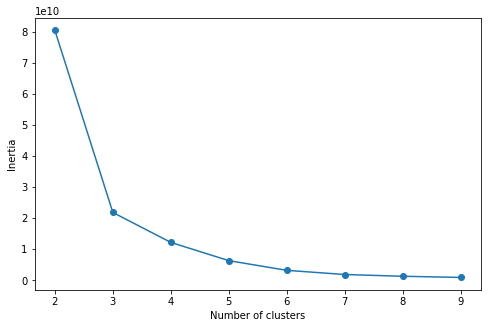

In [82]:
scores=[]
X = buyer.drop(['id','from_city'],axis=1)
for k in tqdm(range(2,10)):
    km = KMeans(n_clusters=k,random_state=42)
    km = km.fit(X)
    scores.append(km.inertia_)
dfk = pd.DataFrame({'Cluster':range(2,10), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

In [83]:
kmeans_labels=KMeans(n_clusters=3,random_state=42).fit_predict(X)

In [84]:
buyer['Clusters'] = kmeans_labels.astype(np.int8)

In [85]:
buyer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286604 entries, 0 to 1286603
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1286604 non-null  int32  
 1   email_domain       1286604 non-null  int16  
 2   gender             1286604 non-null  int8   
 3   category           1286604 non-null  int64  
 4   from_city          1286604 non-null  object 
 5   domisili_count     1286604 non-null  int8   
 6   count              1286604 non-null  int8   
 7   buying             1286604 non-null  float64
 8   refunded           1286604 non-null  float64
 9   spend_time_buying  1286604 non-null  float64
 10  gmv                1286604 non-null  float16
 11  promo              1286604 non-null  float64
 12  Clusters           1286604 non-null  int8   
dtypes: float16(1), float64(4), int16(1), int32(1), int64(1), int8(4), object(1)
memory usage: 83.4+ MB


In [86]:
buyer.describe()

,id,email_domain,gender,category,domisili_count,count,buying,refunded,spend_time_buying,gmv,promo,Clusters
count,1.286604e+06,1.286604e+06,1.286604e+06,1.286604e+06,1.286604e+06,1286604.0,1.286604e+06,1.286604e+06,1.286604e+06,1.286604e+06,1.286604e+06,1.286604e+06
mean,3.469015e+07,3.154714e+03,2.281479e-01,1.372059e+00,1.905481e+00,1.0,2.765413e+00,1.635530e-01,1.394656e+00,NaN,1.079052e+00,2.479318e-01
std,2.392207e+07,1.856010e+03,4.196386e-01,4.833541e-01,1.897603e+00,0.0,5.165215e+00,5.913365e-01,4.976155e+00,0.000000e+00,3.745060e+00,4.644268e-01
min,5.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,-1.388889e-03,-7.539062e+00,0.000000e+00,0.000000e+00
25%,1.228141e+07,2.138000e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,3.083333e-02,-1.015625e+00,0.000000e+00,0.000000e+00
50%,3.138631e+07,2.138000e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,2.183333e-01,-4.978027e-01,0.000000e+00,0.000000e+00
75%,6.014186e+07,2.473000e+03,0.000000e+00,2.000000e+00,2.000000e+00,1.0,3.000000e+00,0.000000e+00,1.591584e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,7.102254e+07,6.788000e+03,1.000000e+00,2.000000e+00,5.000000e+01,1.0,1.400000e+03,6.300000e+01,3.312407e+03,6.812500e+00,1.800000e+02,2.000000e+00


In [87]:
buyer['promo'] = buyer['promo'].astype(np.int16)
buyer['buying'] = buyer['buying'].astype(np.int16)
buyer['refunded'] = buyer['refunded'].astype(np.int16)
buyer['category'] = buyer['category'].astype(np.int8)

In [88]:
buyer.groupby(by='Clusters').size()

Clusters
0    986418
1    281382
2     18804
dtype: int64

In [89]:
grouped = buyer.drop(['id','gender','email_domain','category'],axis=1).groupby(by='Clusters').mean().round(2)
grouped

,domisili_count,count,buying,refunded,spend_time_buying,gmv,promo
Clusters,,,,,,,
0,1.91,1.0,2.74,0.16,1.45,-0.419922,0.99
1,1.91,1.0,2.88,0.17,1.20,-0.479980,1.37
2,1.71,1.0,2.44,0.15,1.17,-0.409912,1.18


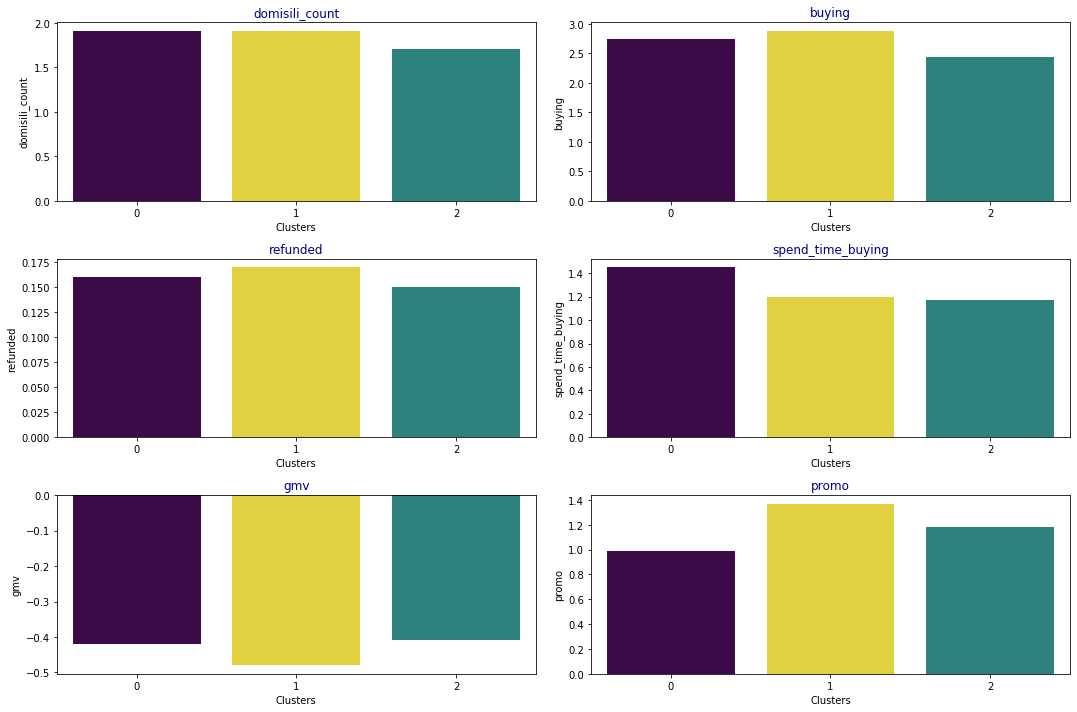

In [90]:
import seaborn as sns
plt.figure(figsize=(15,10))
for i,j in enumerate(grouped.drop('count',axis=1).columns):
    plt.subplot(3,2,i+1)
#     sns.color_palette("Spectral")
    sns.barplot(grouped.index,grouped[j],palette=sns.color_palette(["#420052","#fce725","#1f908a"]))
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

- cluster 0 
(costumer yang sering membeli karena promo, dan tipikal costumer yang kurang teliti terhadap barang yang  dipesan atau kurang puas dengan barang yang dipesan): 
            > memiliki rata rata domisili banyak
            > costumer paling sering membeli, 
            > sering melakukan refunded, 
            > membeli dalam waktu cepat,
            > menghasilkan gmv paling kecil, dan 
            > pengguna promo paling sering
            
- cluster 1
(costumer pemilih yang menentukan barang berdasarkan kualitas dan kebutuhan, bukan membeli karena promo dan paling lama dalam penggunaan aplikasi): 
            > memiliki rata rata domisili banyak, 
            > frekuensi membeli sedang,
            > sering melakukan refunded, 
            > membeli dalam waktu lambat
            > menghasilkan gmv lumayan tinggi, dan 
            > pengguna promo paling rendah
            
- cluster 2:
(costumer yang merasa puas dengan barang yang diterima)
            > memiliki rata rata domisili tidak begitu banyak, 
            > frekuensi membeli rendah,
            > jarang melakukan refunded, 
            > membeli dalam waktu cepat,
            > menghasilkan gmv lumayan tinggi, dan 
            > pengguna promo sedang
            
    


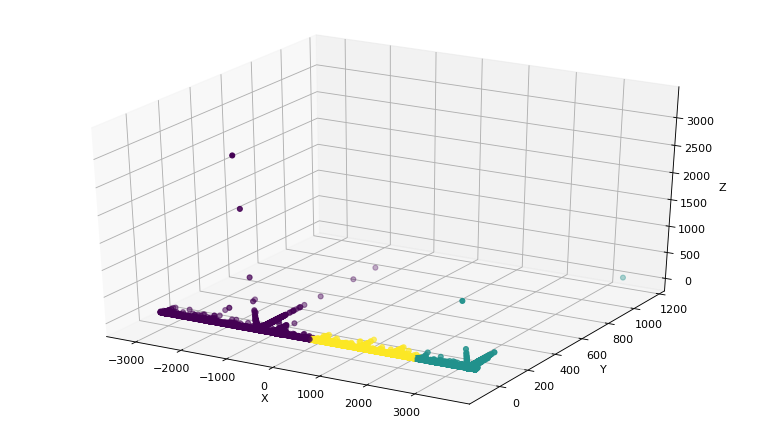

In [91]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
sctt = ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_labels)

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

In [96]:
buyer.to_csv('buyer_info.csv',index=False)